# Создание карты пожаров и пожарных уровней
-----
Для создания карты будем использовать ```mpl_toolkits.basemap``` и ```scipy.stats.binned_statistic_2d```, что бы создать сетку, в которой указано количество пожаров на ячейку карты.

Данные по пожарам будут взяты из **"/Data/.../fires_data.csv"** из корневой папки проекта. Подключим для этого ваш вандрайв, в который загружен требуемый файл

In [ ]:
from google.colab import drive
drive.mount('/content/Data/') # выгружаем содержимое диска в папку /content/Data
# Файловый менеджер GoogleColab можно открыть, нажав на иконку папки слева

Mounted at /content/Data/


In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
from tqdm import tqdm_notebook as tqdm

path_to_fires = '/content/Data/MyDrive/Colab Notebooks/Baseline for MES/Dataset/fires_data1.csv'

fires_table = pd.read_csv(path_to_fires)
fires_table['dt'] = pd.to_datetime(fires_table.dt, format='%Y-%m-%d') # парсим даты
fires_table

,Unnamed: 0,id,dt,lon,lat,type_id,type_name
0,0,573822,2012-01-01,131.8,43.4,3,Горение мусора
1,1,573819,2012-01-01,131.8,43.4,3,Горение мусора
2,2,573818,2012-01-01,133.9,42.9,4,Сжигание порубочных остатков
3,3,573823,2012-01-02,131.3,42.9,4,Сжигание порубочных остатков
4,4,573824,2012-01-02,132.0,43.1,11,Не подтверждено
...,...,...,...,...,...,...,...
727333,727333,2656814,2021-07-11,106.8,62.2,8,Лесной пожар
727334,727334,2656727,2021-07-11,91.9,54.1,11,Не подтверждено
727335,727335,2656718,2021-07-11,96.2,60.4,1,Технологический процесс
727336,727336,2657326,2021-07-11,155.8,62.6,9,Природный пожар


In [ ]:
def get_stats_over_period(table, since, to, fire_type=None, lat = (41,81.5), lon=(19,169)):
  '''
  table -- пандас таблица, откуда брать данные
  since -- дата, с которой рассматривать пожары включительно
  to -- дата, до которой рассматривать пожары включительно
  fire_type -- список идентификаторов пожаров, которые нас интересуют. None если все пожары подходят
  lat -- кортеж из двух чисел как ограничение по широте
  lon -- кортеж из двух чисел как ограничение по долготе
  '''
  if fire_type is None:
    out = table.loc[(table['dt'] <= to) & 
                    (table['dt'] >= since) &
                    (table['lat'] >= lat[0]) &
                    (table['lat'] <= lat[1]) &
                    (table['lon'] >= lon[0]) &
                    (table['lon'] <= lon[1])]
  else:
    # на случай если нам нужны конкретные типы пожаров
    out = table.loc[(table['dt'] <= to) & 
                    (table['dt'] >= since) & 
                    table['type_id'].isin(fire_type) &
                    (table['lat'] >= lat[0]) &
                    (table['lat'] <= lat[1]) &
                    (table['lon'] >= lon[0]) &
                    (table['lon'] <= lon[1])]
  return out

In [ ]:
sliced_fires = get_stats_over_period(fires_table, datetime.datetime(2021,7,1), datetime.datetime(2021,7,1))


In [ ]:
a = sliced_fires['lat'].tolist()
b = sliced_fires['lon'].tolist() # получаю нужные мне данные о координатах пожаров в виде нампаевского массива

In [ ]:
# карта по широте от 41 до 81.5 и по долготе от 19 до 169 градусов с интервалом в 0.25 градуса
l_x = np.arange(41,81.75,0.25)
l_y = np.arange(19,169.25,0.25)
lonslats = np.meshgrid(l_y,l_x)

In [ ]:

def bin_stat(x,y,xl,yl):
  '''
  xl = (from,to,interval)
  yl = (from,to,interval)
  '''

  stat = np.zeros((int((xl[1]-xl[0])/xl[2]),int((yl[1]-yl[0])/yl[2])))
  for (lat,lon) in zip(x,y):
    i = int((lat-xl[0])/xl[2])
    j = int((lon-yl[0])/yl[2])
    stat[i][j] += 1
  return stat


In [ ]:
mgrid = bin_stat(a,b,(41,83,1),(19,170,1))
mgrid.shape

(42, 151)

In [ ]:
# Качать необязательно. Устанавливается для визуального представления содержимого датасета
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.animation as anim

t = range(1,30)

fig,ax = plt.subplots(figsize=(16,7))

m = Basemap(projection='lcc',lon_0=90,lat_0=60,width=7.e6,height=5.e6)
x,y = m(lonslats[0],lonslats[1])

def animate(i):
  ax.clear()
  date = (datetime.datetime(2020,5,1) + datetime.timedelta(days=i))
  sliced_fires = get_stats_over_period(fires_table, date, date)

  a = sliced_fires['lat'].tolist()
  b = sliced_fires['lon'].tolist()
  mgrid = bin_stat(a,b,(41,81.75,0.25),(19,169.25,0.25))
  m.drawcoastlines() # рисуем поверх границы материков
  m.drawcountries() # рисуем поверх границы стран
  draw = m.contourf(x,y,mgrid,np.linspace(0,20,20),cmap=plt.cm.jet,extend='both')
  ax.set_title("Date: " + str(date))
  return draw

animation = anim.FuncAnimation(fig, animate, frames = 120,interval = 50,repeat = False)
animation.save('JulyFires.gif', writer='pillow', fps = 8)



## Подготовим методы и средства для удобного отображения пожаров по запросу даты

In [ ]:
def get_certain_day(data, date, firetype = None, lat_info = (41,83,1), lon_info = (19,170,1)):
  '''
  data : пандас таблица откуда брать данные
  date : datetime дата, в какой день брать данные
  firetype : список идентификаторов огня, которые нас интересуют
  lat_info : кортеж из информации с какой широты до какой широты с каким шагом
  lon_info : кортеж из информации с какой долготы до какой долготы с каким шагом

  Возвращает таблицу соответствующую карте пожаров и координатную плоскость
  '''
  stats = get_stats_over_period(data, date, date, firetype, (lat_info[0],lat_info[1]),(lon_info[0],lon_info[1]))
  stats_lat = stats['lat'].tolist()
  stats_lon = stats['lon'].tolist()

  l_x = np.arange(*lat_info)
  l_y = np.arange(*lon_info)
  lonslats = np.meshgrid(l_y,l_x)

  mgrid = bin_stat(stats_lat,stats_lon,lat_info,lon_info)
  
  return (mgrid, lonslats) 

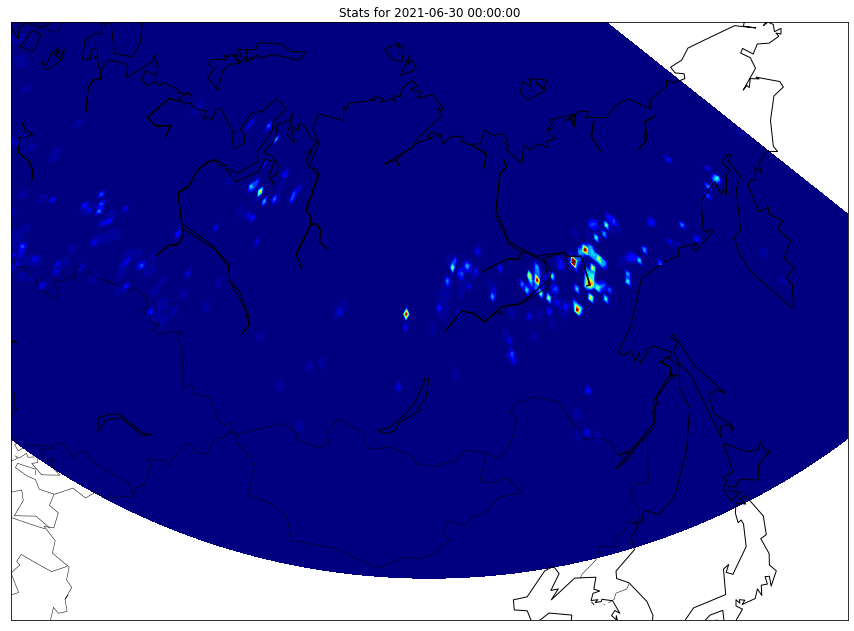

In [ ]:
fig = plt.figure(figsize=(15,35)) # задаем настройки изображений карт
m = Basemap(projection='lcc',lon_0=110,lat_0=60,width=7.e6,height=5.e6) # используем Basemap для отображения
# указываем тип проекции (можно ошибиться и в ошибке укажет существующие типы)
# указываем ориентировочные долготу и высоту, а также размер карты (для указанного типа проекции)
certain_day = datetime.datetime(2021,6,30)
inner_info = get_certain_day(fires_table, certain_day, firetype = None, lat_info = (41,83,0.5), lon_info = (19,170,0.5))

x,y = m(inner_info[1][0],inner_info[1][1]) # запоминаем систему координат

ax = plt.subplot()
m.drawcoastlines() # рисуем поверх границы материков
m.drawcountries() # рисуем поверх границы стран 
cs = m.contourf(x,y,inner_info[0],np.linspace(0,20,20),cmap=plt.cm.jet,extend='both') # накладываем градиент температур
t = plt.title('Stats for '+str(certain_day))
# важно правильно указать градиент, чтобы корректно видеть что отображается на карте. (четвертый и пятый параметры)